In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data

In [3]:
data = pd.read_csv('data/cs-training.csv', index_col=0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
target_col = 'SeriousDlqin2yrs'

## Splitting into Training and Dev Sets

In [5]:
train = data.sample(n=120000, random_state=3)
dev = data[~data.index.isin(train.index)]
train[target_col].value_counts(normalize=True), dev[target_col].value_counts(normalize=True)

(0    0.933217
 1    0.066783
 Name: SeriousDlqin2yrs, dtype: float64, 0    0.932933
 1    0.067067
 Name: SeriousDlqin2yrs, dtype: float64)

## Cleaning Data

In [6]:
def clean_data(df, income_mv, dependent_mv):
    """
    Imputes missing values
    Floors & ceils the outliers
    Combines smaller categories into a single category
    """
    
    df.columns = [col.replace('-', '_') for col in df.columns]
    
    # RevolvingUtilizationOfUnsecuredLines
    df.loc[df['RevolvingUtilizationOfUnsecuredLines'] >1, 'RevolvingUtilizationOfUnsecuredLines'] = 1
    
    # age
    df.loc[df['age']< 21, 'age'] = 21
    
    # NumberOfTime30-59DaysPastDueNotWorse
    df.loc[df['NumberOfTime30_59DaysPastDueNotWorse']>=2, 'NumberOfTime30_59DaysPastDueNotWorse'] = 2
    
    # NumberOfTime60-89DaysPastDueNotWorse
    df.loc[df['NumberOfTime60_89DaysPastDueNotWorse']>=1, 'NumberOfTime60_89DaysPastDueNotWorse'] = 1
    
    # NumberOfTimes90DaysLate
    df.loc[df['NumberOfTimes90DaysLate']>=1, 'NumberOfTimes90DaysLate'] = 1
    
    # MonthlyIncome
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(income_mv) #replace with median
    
    # NumberOfOpenCreditLinesAndLoans

    # NumberRealEstateLoansOrLines
    df.loc[df['NumberRealEstateLoansOrLines']>=3, 'NumberRealEstateLoansOrLines'] = 3
    
    # NumberOfDependents
    df.loc[df['NumberOfDependents']>=3, 'NumberOfDependents'] = 3
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(dependent_mv) #replace with median
    
    return df



In [7]:
train = clean_data(train, 5400, 0)
dev = clean_data(dev, 5400, 0)

In [8]:
def get_bins_from_training_data(df):
    '''bin variables based on the eda done in the other notebook'''
    binsdf = {}
    _, binsdf['RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df['RevolvingUtilizationOfUnsecuredLines'], 5, retbins=True, labels=None)
    _, binsdf['DebtRatio'] = pd.qcut(df['DebtRatio'], 5, retbins=True, labels=None)
    _, binsdf['age'] = pd.qcut(df['age'], 5, retbins=True, labels=None)
    _, binsdf['MonthlyIncome'] = pd.qcut(df['MonthlyIncome'], 4, retbins=True, labels=None)
    _, binsdf['NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df['NumberOfOpenCreditLinesAndLoans'], 5, retbins=True, labels=None)
    return binsdf

binsdf = get_bins_from_training_data(train)

In [93]:
def create_bins(df, binsdf):
    '''create bins on the unseen data set'''
    retdf = pd.DataFrame()
    for column in df.columns:
        if column in binsdf.keys():
            retdf[column] = pd.cut(df[column], bins=binsdf[column], labels=False, include_lowest=True)
        else:
            retdf[column] = df[column].copy(deep=True)
    return retdf

def create_bins_2(df, binsdf):
    '''create bins on the unseen data set'''
    retdf = pd.DataFrame()
    for column in df.columns:
        if column in binsdf.keys():
            retdf[column] = pd.cut(df[column], bins=binsdf[column], include_lowest=True)
        else:
            retdf[column] = df[column].copy(deep=True)
    return retdf

train_binned_df = create_bins(train, binsdf)
dev_binned_df = create_bins(dev, binsdf)

train_binned_df_2 = create_bins_2(train, binsdf)
dev_binned_df_2 = create_bins_2(dev, binsdf)

In [10]:
def weight_of_evidence(df, labelcol, col, categorical_col=None):
    '''calculates weight of evidence values for each category in a given variable (col)'''
    if categorical_col is None:
        categorical_col = col
    
    tempdf = df.groupby(by=categorical_col).agg({labelcol:{
                                                        '_counts': 'size',
                                                        '_bads': lambda x: len(x[x==1]),
                                                        '_goods': lambda x: len(x[x==0])
                                                    }})
    tempdf.columns  = [col+ column for column in tempdf.columns.droplevel(0)]
    tempdf[col+'_distri_tot'] = tempdf[col+'_counts']/(tempdf[col+'_counts'].sum())
    tempdf[col+'_distri_bads'] = tempdf[col+'_bads']/(tempdf[col+'_bads'].sum())
    tempdf[col+'_distri_goods'] = tempdf[col+'_goods']/(tempdf[col+'_goods'].sum())
    tempdf[col+'_bad_rate'] = tempdf[col+'_bads']/tempdf[col+'_counts']
    tempdf[col+'_woe'] = np.log(tempdf[col+'_distri_goods']) - np.log(tempdf[col+'_distri_bads'])
    return tempdf


def information_value(df, col):
    '''calculates Information Value using the Weight of evidence scores'''
    df['diff_col'] = df[col+'_distri_goods'] - df[col+'_distri_bads']
    return np.sum(df['diff_col']*df[col+'_woe'])


In [11]:
def get_woe_from_training_data(binned_df):
    '''calculates the wWeight of Evidence and Information Values based on the training data set for all the features'''
    woe_dict = {}
    iv_dict = {}
    for column in binned_df.columns:
        if column == target_col:
            pass
        else:
            woe_df = weight_of_evidence(binned_df, target_col, column)
            woe_column = [col for col in woe_df.columns if 'woe' in col][0]
            woe_dict[column] = dict(woe_df[woe_column])
            iv_dict[column] = information_value(woe_df, column)
    return woe_dict, iv_dict
 

woe, iv = get_woe_from_training_data(create_bins(train, binsdf))

In [12]:
iv = pd.DataFrame.from_dict(iv, orient='index')
iv.columns = ['information_value']
iv.sort_values(by='information_value', ascending=False)

,information_value
RevolvingUtilizationOfUnsecuredLines,1.051496
NumberOfTimes90DaysLate,0.822086
NumberOfTime30_59DaysPastDueNotWorse,0.736713
NumberOfTime60_89DaysPastDueNotWorse,0.562831
age,0.240657
MonthlyIncome,0.061015
NumberRealEstateLoansOrLines,0.057126
DebtRatio,0.054804
NumberOfOpenCreditLinesAndLoans,0.048957
NumberOfDependents,0.032749


In [13]:
def create_woe(binned_df, woe):
    '''Applies the calculated WoE values on the unseen data set'''
    for column in woe.keys():
        binned_df[column] = binned_df[column].map(woe[column])
    return binned_df

train_woe = create_woe(train_binned_df, woe)
dev_woe =  create_woe(dev_binned_df, woe)

In [14]:
train_woe.columns = [col.replace('-', '_') for col in train_woe.columns]
dev_woe.columns = [col.replace('-', '_') for col in dev_woe.columns]
train_woe.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

## Model

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [16]:
formula = " SeriousDlqin2yrs ~ "\
            +"RevolvingUtilizationOfUnsecuredLines +"\
            +"age +"\
            +"DebtRatio + "\
            +"MonthlyIncome + "\
            +"NumberOfTime30_59DaysPastDueNotWorse +"\
            +"NumberOfTime60_89DaysPastDueNotWorse +"\
            +"NumberOfTimes90DaysLate +"\
            +"NumberOfOpenCreditLinesAndLoans +"\
            +"NumberRealEstateLoansOrLines +"\
            +"NumberOfDependents"
func=smf.glm(formula=formula,data=train_woe,family=sm.families.Binomial()).fit(maxiter=1000)
func.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               120000
Model:                            GLM   Df Residuals:                   119989
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22136.
Date:                Fri, 10 Jan 2020   Deviance:                       44271.
Time:                        06:15:34   Pearson chi2:                 1.04e+05
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.6109      0.014   -185.004      0.000      -2.639      -2.583
RevolvingUtilizationOfUnsecuredLines    -0.6133      0.014    -43.389      0.000      -0.641      -0.586
age                                     -0.4164      0.031    -13.637      0.000      -0.476      -0.357
DebtRatio                               -0.8189      0.058    -14.222      0.000      -0.932      -0.706
MonthlyIncome                           -0.1825      0.055     -3.314      0.001      -0.290      -0.075
NumberOfTime30_59DaysPastDueNotWorse    -0.5305      0.014    -36.613      0.000      -0.559      -0.502
NumberOfTime60_89DaysPastDueNotWorse    -0.4098      0.016    -26.047      0.000      -0.441      -0.379
NumberOfTimes90DaysLate                 -0.5397      0.013    -41.854      0.000      -0.565      -0.514
NumberOfOpenCreditLinesAndLoans         -0.0077      0.063     -0.121      0.903      -0.132       0.117
NumberRealEstateLoansOrLines            -0.6022      0.060     -9.973      0.000      -0.720      -0.484
NumberOfDependents                      -0.2128      0.074     -2.869      0.004      -0.358      -0.067
========================================================================================================
"""

We remove the NumberOfOpenCreditLinesAndLoans as it is not significant by p-value (0.9) and make the model again

In [17]:
formula = " SeriousDlqin2yrs ~ "\
            +"RevolvingUtilizationOfUnsecuredLines +"\
            +"age +"\
            +"DebtRatio + "\
            +"MonthlyIncome + "\
            +"NumberOfTime30_59DaysPastDueNotWorse +"\
            +"NumberOfTime60_89DaysPastDueNotWorse +"\
            +"NumberOfTimes90DaysLate +"\
            +"NumberRealEstateLoansOrLines +"\
            +"NumberOfDependents"

func=smf.glm(formula=formula,data=train_woe,family=sm.families.Binomial()).fit(maxiter=1000)

In [18]:
func.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               120000
Model:                            GLM   Df Residuals:                   119990
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22136.
Date:                Fri, 10 Jan 2020   Deviance:                       44271.
Time:                        06:15:34   Pearson chi2:                 1.04e+05
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.6109      0.014   -185.005      0.000      -2.639      -2.583
RevolvingUtilizationOfUnsecuredLines    -0.6136      0.014    -44.087      0.000      -0.641      -0.586
age                                     -0.4165      0.031    -13.643      0.000      -0.476      -0.357
DebtRatio                               -0.8178      0.057    -14.391      0.000      -0.929      -0.706
MonthlyIncome                           -0.1834      0.055     -3.359      0.001      -0.290      -0.076
NumberOfTime30_59DaysPastDueNotWorse    -0.5303      0.014    -36.966      0.000      -0.558      -0.502
NumberOfTime60_89DaysPastDueNotWorse    -0.4098      0.016    -26.047      0.000      -0.441      -0.379
NumberOfTimes90DaysLate                 -0.5399      0.013    -42.273      0.000      -0.565      -0.515
NumberRealEstateLoansOrLines            -0.6036      0.059    -10.189      0.000      -0.720      -0.487
NumberOfDependents                      -0.2123      0.074     -2.867      0.004      -0.357      -0.067
========================================================================================================
"""

In [19]:
# saving model
func.save('model_9_variables_1.pkl')

### Checking performance

-----   Training Set Performance   --------

ROC_AUC:  0.85414757649726
Somersd:  0.7082951529945201


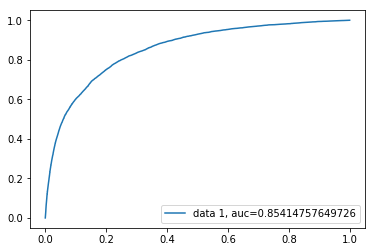

In [20]:
import sklearn.metrics as setrics

def get_metrics(df, model, label_col='status_2_yrs'):
    '''plots roc-auc and calcualtes somers-d score'''
    roc_auc = setrics.roc_auc_score(df[label_col],  model.predict(df))
    print('ROC_AUC: ', roc_auc)
    
    somersd = 2*roc_auc -1
    print('Somersd: ', somersd)
    
    fpr, tpr, _ = setrics.roc_curve(df[label_col],  model.predict(df))
    plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

print('-----   Training Set Performance   --------\n')    
get_metrics(train_woe, func, label_col='SeriousDlqin2yrs')

-----   Dev Set Performance   --------

ROC_AUC:  0.8623952259429915
Somersd:  0.7247904518859829


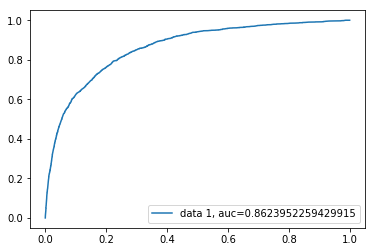

In [21]:
print('-----   Dev Set Performance   --------\n')    

get_metrics(dev_woe.dropna(), func, label_col='SeriousDlqin2yrs')

## Scorecard

### Calculating Offset

Let's set the odds of 50:1 at a score of 600

In [63]:
score= 600
odds = 50
pdo = 20
factor = pdo/np.log(2)

offset = score - np.log(odds)*factor
offset

487.1228762045055

In [64]:
def make_scorecard(woe_df, model, pdo=20, offset_score=600):
    '''calculates credit score'''
    features = model.params.index.values[1:]
    factor = pdo/np.log(2)
    n = len(features)
    offset = offset_score - np.log(50)*factor
    
    scorecard = -(((woe_df[features]*(model.params.iloc[1:])).sum(axis=1)) + model.params.Intercept)*factor +  offset
    return scorecard

In [68]:
train_scorecard = make_scorecard(train_woe, func, offset_score=600)
dev_scorecard = make_scorecard(dev_woe, func, offset_score=600)

In [69]:
train['credit_score'] = train_scorecard
train.to_csv('output/train_credit_scores.csv')

dev['credit_score'] = dev_scorecard
dev.to_csv('output/dev_credit_scores.csv')

## Predicting on Test Data

In [67]:
test = pd.read_csv('data/cs-test.csv', index_col=0)
test.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [26]:
test = clean_data(test, 5400, 3)
test_binned_df = create_bins(test, binsdf)
test_woe = create_woe(test_binned_df, woe)
test_scorecard = make_scorecard(test_woe, func)
test_scorecard.describe()

count    101503.000000
mean        695.353465
std          34.102913
min         540.370848
25%         677.351574
50%         704.746386
75%         721.206900
max         741.375176
dtype: float64

In [27]:
test['credit_score'] = test_scorecard
test.to_csv('output/test_credit_scores.csv')

### Score distribution

In [70]:
dev['credit_score'] = dev_scorecard

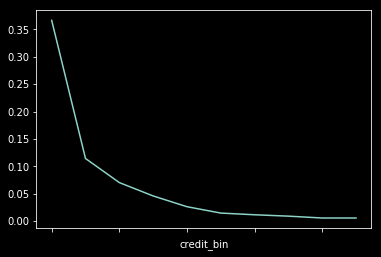

In [143]:
# plt.style.use('dark_background')
dev['credit_bin'] = pd.qcut(dev['credit_score'], 10)
dev.groupby(by='credit_bin').agg('mean')[target_col].plot()

In [72]:
score_bins['min_score'] = score_bins['credit_bin'].apply(lambda x: int(x.left))
score_bins['max_score'] = score_bins['credit_bin'].apply(lambda x: int(x.right))
score_bins.columns = ['credit_bin', 'default_rate', 'min_score', 'max_score']
score_bins = score_bins[['credit_bin', 'min_score', 'max_score', 'default_rate']]
score_bins

,credit_bin,min_score,max_score,default_rate
0,"(430.624, 538.367]",430,538,36.7
1,"(538.367, 557.479]",538,557,11.4
2,"(557.479, 571.337]",557,571,7.0
3,"(571.337, 583.009]",571,583,4.6
4,"(583.009, 591.473]",583,591,2.6
5,"(591.473, 598.97]",591,598,1.5
6,"(598.97, 605.128]",598,605,1.2
7,"(605.128, 610.527]",605,610,0.9
8,"(610.527, 616.943]",610,616,0.6
9,"(616.943, 628.498]",616,628,0.6


In [75]:
variables = list(func.params[1:].index)
variables

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfTime30_59DaysPastDueNotWorse',
 'NumberOfTime60_89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfDependents']

In [102]:
dev_binned_df_3 = dev_binned_df_2.join(dev_woe, rsuffix='_woe')
dev_binned_df_3.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,...,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
7,0,"(0.27, 0.6970000000000001]","(56.0, 65.0]",0,"(3.62, 329664.0]","(3900.0, 5400.0]","(6.0, 9.0]",0,3,0,...,-0.041499,0.412348,0.538239,0.198680,0.017534,0.230913,0.384389,-0.235988,0.285051,0.145361
9,0,"(0.0828, 0.27]","(20.999, 39.0]",0,"(3.62, 329664.0]","(3900.0, 5400.0]","(-0.001, 4.0]",0,0,0,...,0.856237,-0.491161,0.538239,0.198680,0.017534,-0.351146,0.384389,-0.243963,0.285051,0.145361
13,0,"(-0.001, 0.019100000000000002]","(39.0, 48.0]",0,"(0.28700000000000003, 0.468]","(7373.25, 1794060.0]","(12.0, 57.0]",0,2,0,...,1.300265,-0.238303,0.538239,0.073002,0.368569,0.001339,0.384389,0.206687,0.285051,-0.191095
20,0,"(0.27, 0.6970000000000001]","(20.999, 39.0]",0,"(-0.001, 0.134]","(-0.001, 3900.0]","(-0.001, 4.0]",0,0,0,...,-0.041499,-0.491161,0.538239,0.093126,-0.328794,-0.351146,0.384389,-0.243963,0.285051,0.145361
25,0,"(0.019100000000000002, 0.0828]","(56.0, 65.0]",0,"(0.134, 0.28700000000000003]","(-0.001, 3900.0]","(6.0, 9.0]",0,1,0,...,1.407820,0.412348,0.538239,0.158030,-0.328794,0.230913,0.384389,0.253011,0.285051,0.145361


In [127]:
score_list = []
for variable in variables:
    for val in dev_binned_df_3[variable+'_woe'].unique():
        try:
            temp_list = []
            temp_list.append(variable)
            _bin = dev_binned_df_3[dev_binned_df_3[variable+'_woe']==val][variable].mode().values[0]
#             if isinstance(_bin, Interval):
#                 _bin = (_bin.left, _bin.right)
            temp_list.append(_bin)
            temp_list.append((val*func.params[variable] +\
                                         func.params['Intercept']/len(variables))*20/np.log(2) + \
                                        offset/len(variables))
            score_list.append(pd.Series(temp_list))
        except:
            pass
      

In [132]:
score_df = pd.concat(score_list, axis=1).T
score_df.columns = ['variable', 'bin', 'score']
score_df

,variable,bin,score
0,RevolvingUtilizationOfUnsecuredLines,"(0.6970000000000001, 1.0]",67.7531
1,RevolvingUtilizationOfUnsecuredLines,"(0.27, 0.6970000000000001]",46.4889
2,RevolvingUtilizationOfUnsecuredLines,"(0.0828, 0.27]",30.5946
3,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.019100000000000002]",22.7332
4,RevolvingUtilizationOfUnsecuredLines,"(0.019100000000000002, 0.0828]",20.8289
5,age,"(20.999, 39.0]",51.6563
6,age,"(39.0, 48.0]",48.6178
7,age,"(48.0, 56.0]",46.6261
8,age,"(56.0, 65.0]",40.7991
9,age,"(65.0, 109.0]",33.2097


In [136]:
type(score_df['bin'].iloc[-2])

numpy.float64

In [140]:
score_df['left'] = score_df['bin'].apply(lambda x:x if (isinstance(x, np.int64) or isinstance(x, np.float64)) else x.left)
# score_df['right'] = score_df['bin'].apply(lambda x:x if (isinstance(x, np.int64) or isinstance(x, np.float64)) else x.left)

In [152]:
some_df = score_df.sort_values(by=['variable', 'left'], ascending=True).drop(columns=['left'])
some_df.to_csv('tt.csv')

In [108]:
type(dev_binned_df_3[dev_binned_df_3[variable+'_woe']==val][variable].mode())

numpy.float64

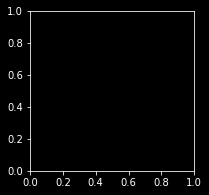

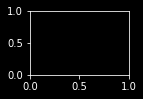

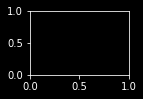

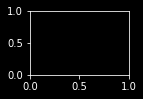

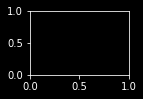

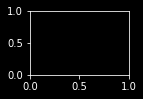

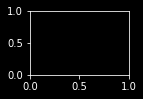

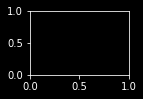

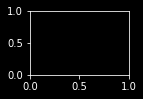

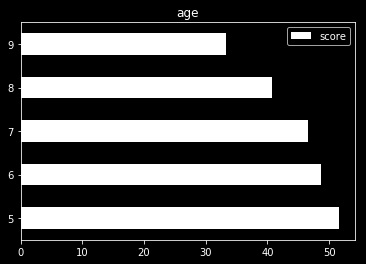

In [150]:


fig = plt.figure(figsize=(10,10))

for i, variable in enumerate(some_df['variable'].unique()):
    var_df= some_df[some_df['variable']==variable]
    plt.subplot(3,3,i+1)
    var_df['score'].plot(kind='barh', title=variable, color='white')